In [1]:
%pylab inline
import matplotlib.pyplot as plt
import PIL
import numpy as np
import math
from glob import glob
from scipy.cluster.vq import kmeans
from collections import defaultdict, deque

Populating the interactive namespace from numpy and matplotlib


In [2]:
def dist(c1, c2):
    return ((c1 - c2)**2).sum() ** 0.5

In [3]:
def get_penalty(img, classes, centers, penalty_coefs=(1,1)):
    assert len(centers) == 2
    result = np.array([0.0, 0.0])
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            result[0] += dist(img[x][y], centers[classes[x][y]])
            if x < img.shape[0] - 1 and classes[x][y] != classes[x+1][y]:
                result[1] += edge_penalty(img[x][y], img[x+1][y])
            if y < img.shape[1] - 1 and classes[x][y] != classes[x][y+1]:
                result[1] += edge_penalty(img[x][y], img[x][y+1])
    return (result * penalty_coefs).sum()

In [4]:
def edge_penalty(c1, c2):
    return 1 / (1 + dist(c1, c2) / 255)

In [5]:
def apply_cut(img, classes, centers, klass=1):
    assert len(centers) == 2
    result = img // 1
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if classes[x][y] == klass:
                 pass
            else:
                result[x][y] = [255, 255, 255]
    result = np.clip(result, 0, 255)
    return result

In [6]:
def process_img(img_file, cut_func, centers, show=False, penalty_coefs=(1,1)):
    img = np.array(PIL.Image.open(img_file))[:, :, :3].astype('int64')

    centers = np.array(centers)
    classes = cut_func(img, centers, penalty_coefs)
    penalty = get_penalty(img, classes, centers, penalty_coefs)
    first_clustered = apply_cut(img, classes, centers, 0)
    second_clustered = apply_cut(img, classes, centers, 1)
    
    if show:
        fig = plt.figure(figsize=(16, 8))
        fig.add_subplot(221)
        plt.imshow(img)

        fig.add_subplot(223)
        plt.imshow(first_clustered)
        
        fig.add_subplot(224)
        plt.imshow(second_clustered)
        plt.show()

    return (penalty, classes)

In [7]:
def simple_get_centers(img_file):
    img = np.array(PIL.Image.open(img_file))[:, :, :3].astype('float').reshape((-1, 3))
    return kmeans(img.astype('float'), 2)[0].astype('int64')

In [8]:
def simple_cut(img, centers, coefs):
    assert len(centers) == 2
    classes = np.zeros_like(img[:, :, 0])
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if dist(img[x][y], centers[0]) < dist(img[x][y], centers[1]):
                classes[x][y] = 0
            else:
                classes[x][y] = 1
    return classes

In [9]:
#Алгоритм Диница
def min_cut(img, centers, coefs=(1,1)):
    def find_levels():
        q = deque()
        q.append('source')
        levels['source'] = 0
        while len(q) > 0:
            cur = q.popleft()
            for v in graph[cur]:
                if levels[v] == -1 and graph[cur][v] > 0:
                    q.append(v)
                    levels[v] = levels[cur] + 1
        return levels['sink'] >= 0
    
    def send_flow(u, flow=math.inf):
        if u == 'sink' or flow == 0:
            return flow
        keys = [*graph[u].keys()]
        while start[u] < len(graph[u]):
            v = keys[start[u]]
            if (levels[v] == levels[u] + 1 and graph[u][v] > 0):
                cur_flow = min(flow, graph[u][v])
                temp_flow = send_flow(v, cur_flow)
                if temp_flow > 0:
                    graph[u][v] -= temp_flow
                    graph[v][u] += temp_flow
                    return temp_flow
            start[u] += 1
        return 0
    
    def build_classes():
        classes = np.zeros_like(img[:, :, 0])
        visited = defaultdict(lambda: False)
        q = deque()
        q.append('source')
        visited['source'] = True
        while len(q) > 0:
            cur = q.popleft()
            for v in graph[cur]:
                if not visited[v] and graph[cur][v] > 0:
                    q.append(v)
                    visited[v] = True
                    classes[v[0]][v[1]] = 1
        return classes
    
    graph = defaultdict(lambda: defaultdict(lambda: 0.0))
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if x - 1 >= 0:
                graph[(x,y)][(x-1,y)] = edge_penalty(img[x][y], img[x-1][y]) * coefs[1]
            if x + 1 < img.shape[0]:
                graph[(x,y)][(x+1,y)] = edge_penalty(img[x][y], img[x+1][y]) * coefs[1]
            if y - 1 >= 0:
                graph[(x,y)][(x,y-1)] = edge_penalty(img[x][y], img[x][y-1]) * coefs[1]
            if y + 1 < img.shape[1]:
                graph[(x,y)][(x,y+1)] = edge_penalty(img[x][y], img[x][y+1]) * coefs[1]
            graph['source'][(x,y)] = dist(img[x][y], centers[0]) * coefs[0]
            graph[(x,y)]['sink'] = dist(img[x][y], centers[1]) * coefs[0]
    
    levels = defaultdict(lambda: -1)
    while find_levels():
        start = defaultdict(int)
        flow = send_flow('source')
        while flow > 0:
            flow = send_flow('source')
        levels = defaultdict(lambda: -1)

    return build_classes()

In [12]:
def process_img1(img, cut_func, c, coefs=(1,1)):
    simple_cut_penalty, simple_cut_classes = process_img(img, simple_cut, c, coefs)
    cut_penalty, cut_classes = process_img(img, cut_func, c, show, coefs)
    return 

Запустим с коэффициентами $\alpha = 1$ и $\beta = 1 $

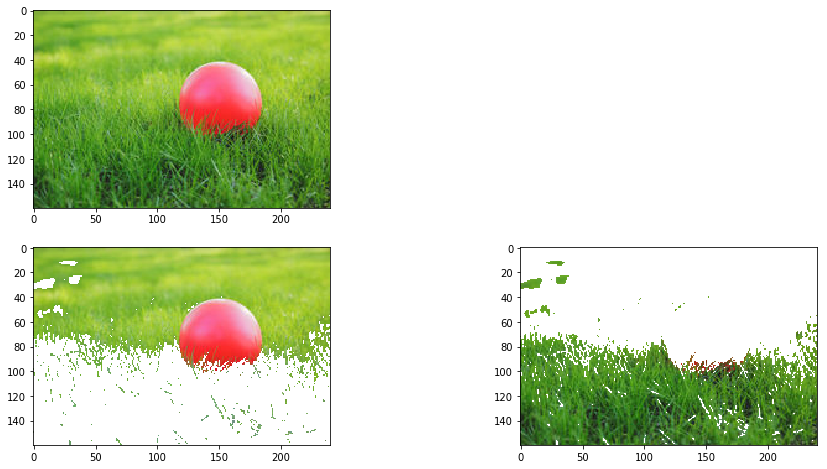

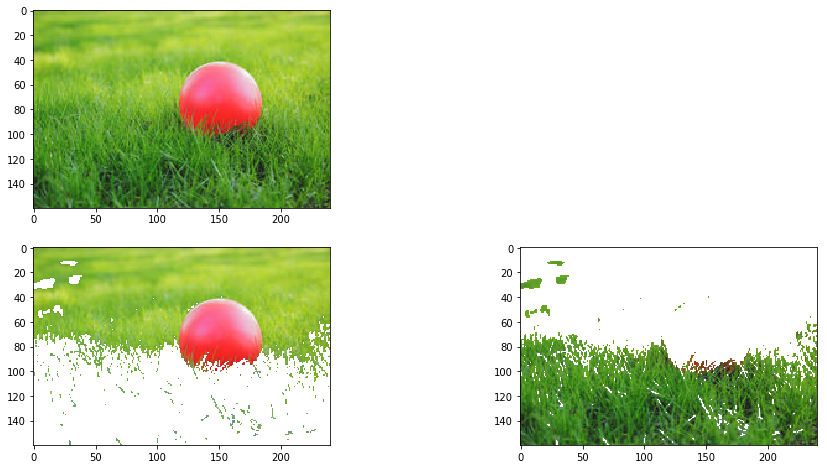

In [11]:
for img in glob('imgs/*'):
    if img != 'imgs/test2.jpg':
        c = simple_get_centers(img)
        process_img1(img, min_cut, c)

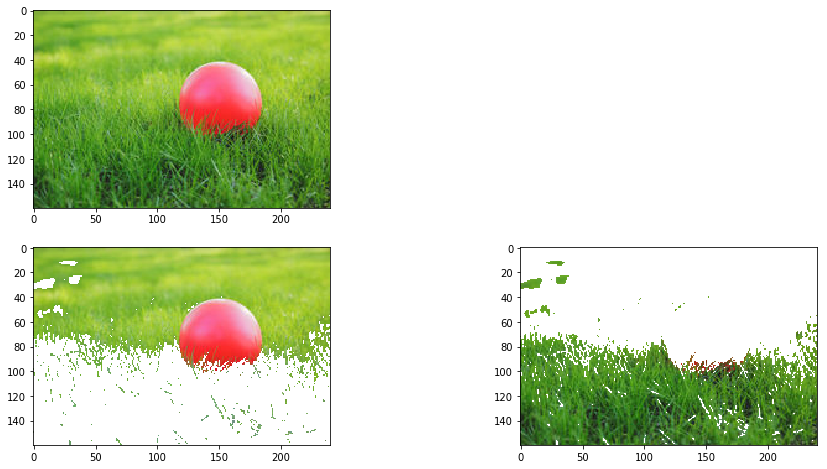

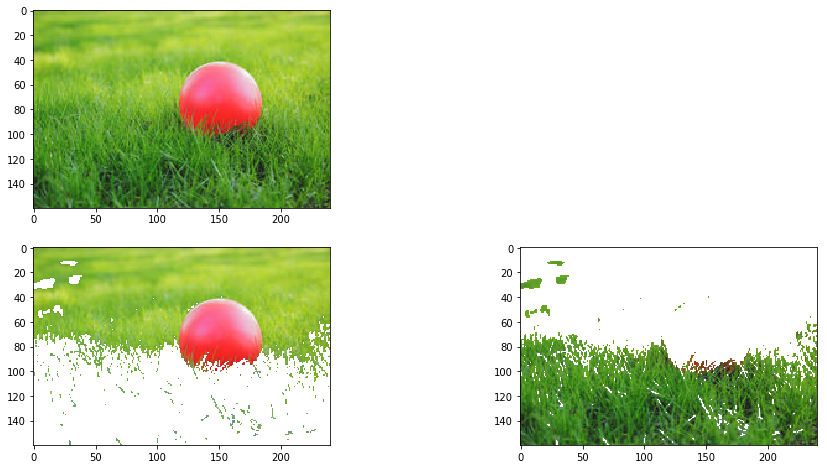

In [12]:
for img in glob('imgs/*'):
    c = simple_get_centers(img)
    process_img1(img, min_cut, c, (0.5, 0.5))

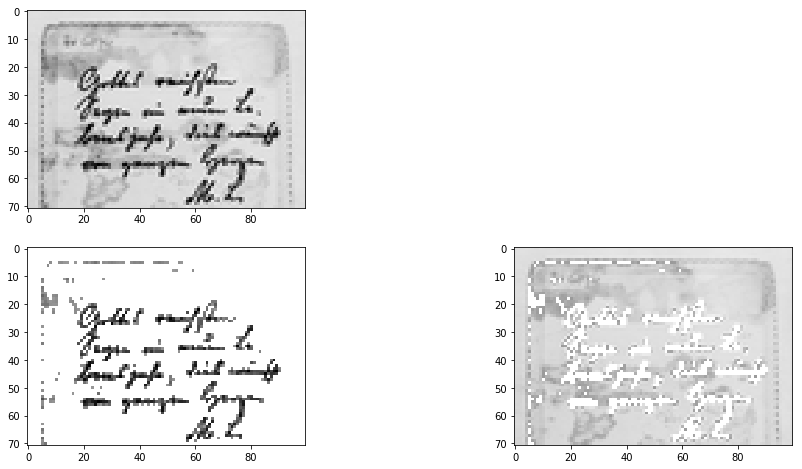

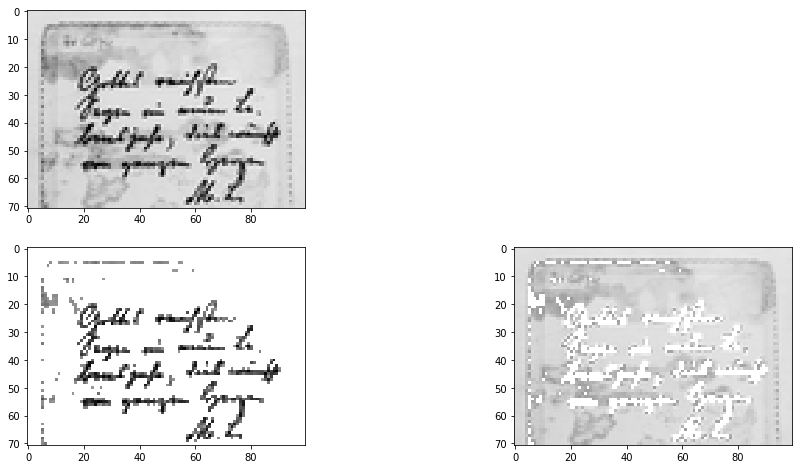

In [13]:
img = 'test0.bmp'
c = simple_get_centers(img)
process_img1(img, min_cut, c, (0.5, 0.5))

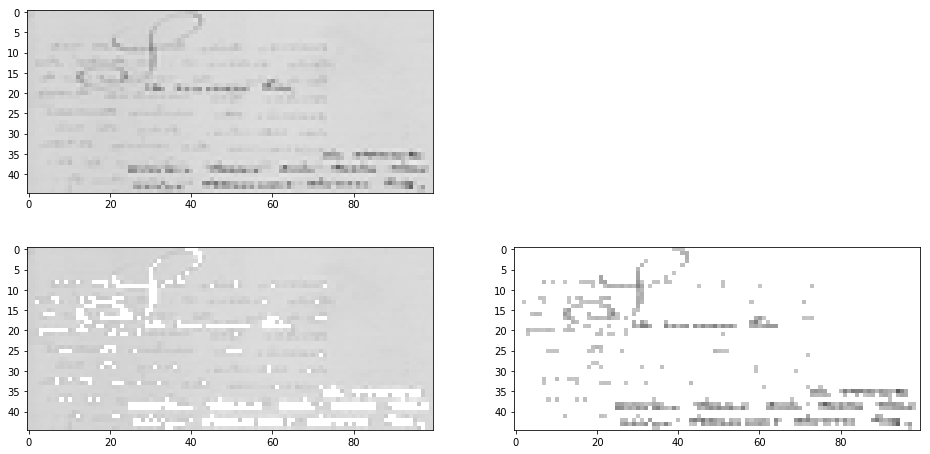

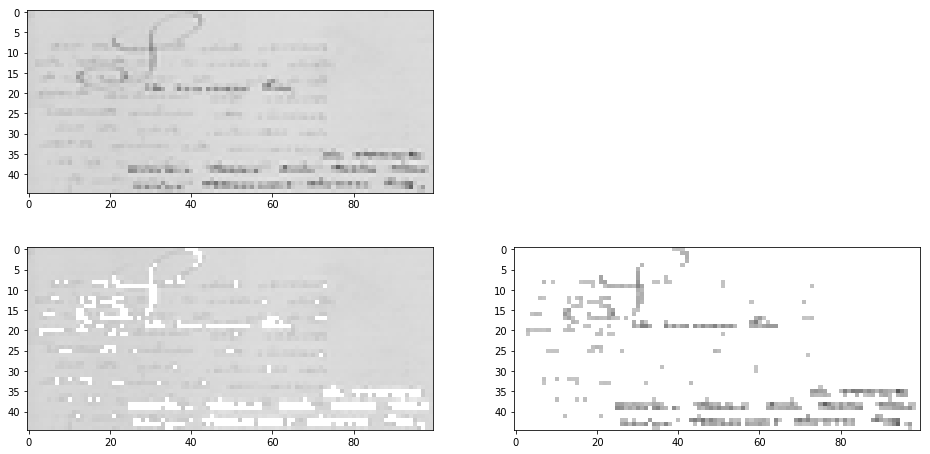

In [14]:
img = 'test00.bmp'
c = simple_get_centers(img)
process_img1(img, min_cut, c, (0.5, 0.5))

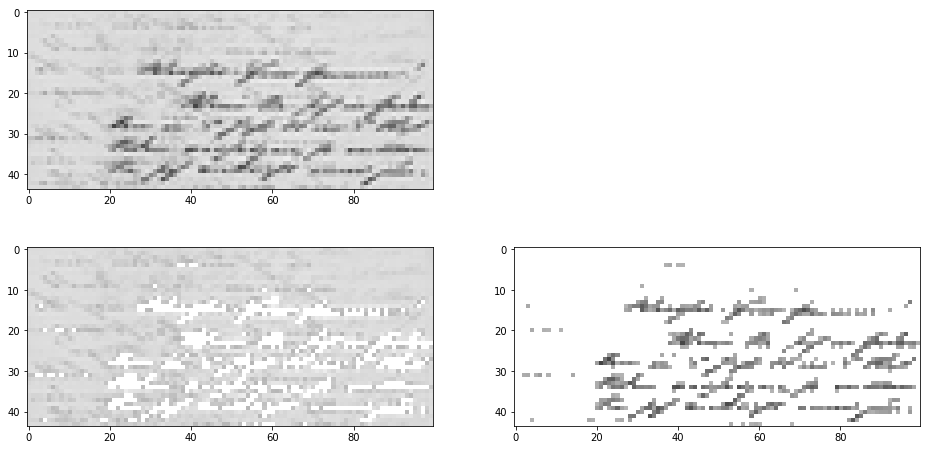

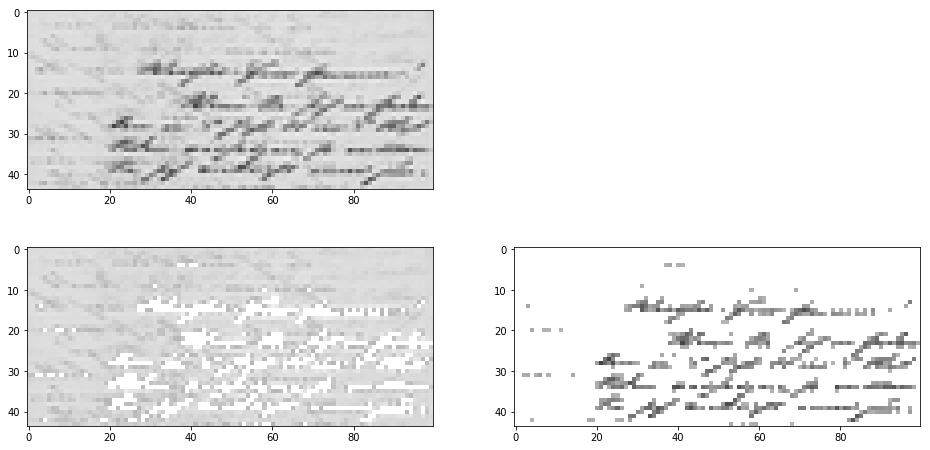

In [15]:
img = 'test000.bmp'
c = simple_get_centers(img)
process_img1(img, min_cut, c, (0.5, 0.5))

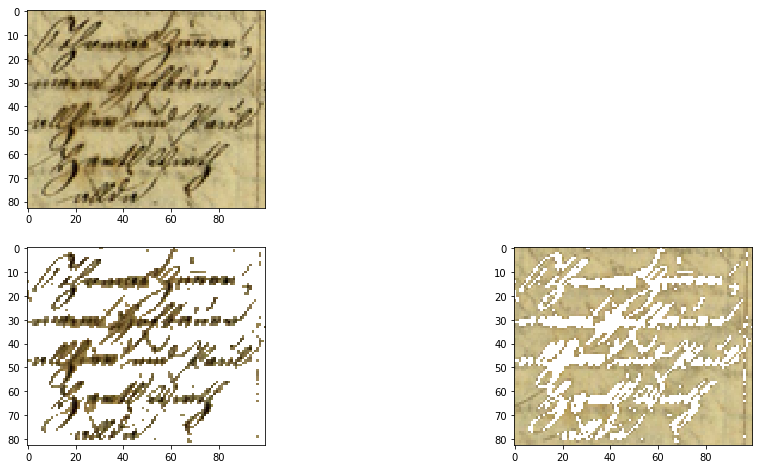

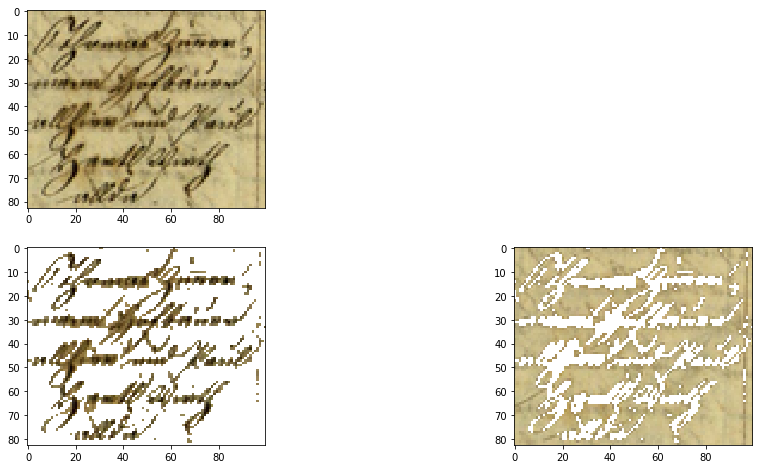

In [16]:
img = 'test00000.bmp'
c = simple_get_centers(img)
process_img1(img, min_cut, c, (0.5, 0.5))

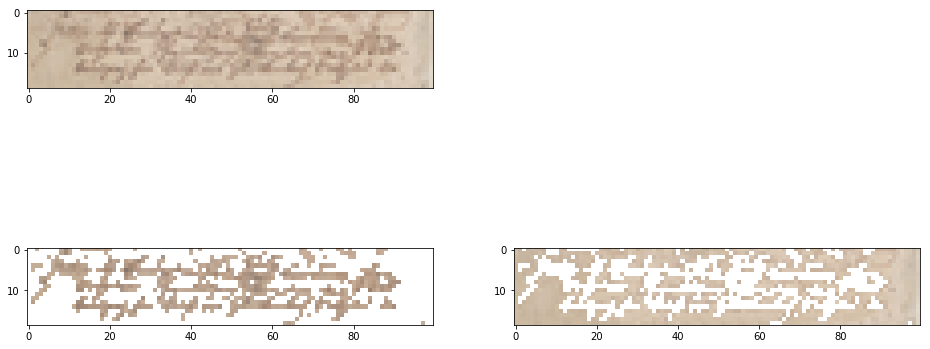

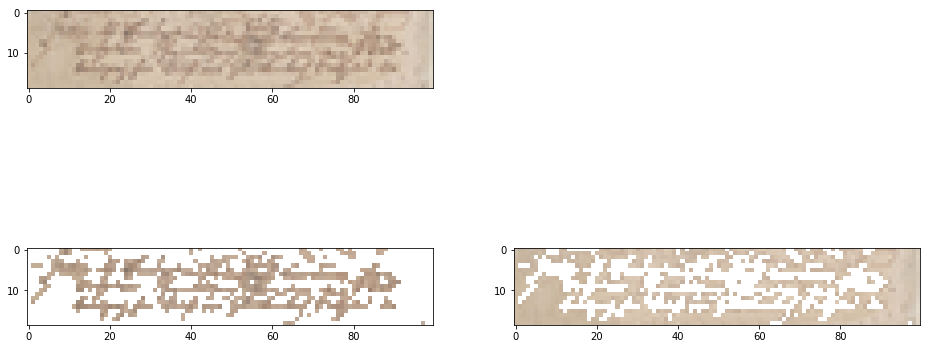

In [17]:
img = 'test0000.bmp'
c = simple_get_centers(img)
process_img1(img, min_cut, c, (0.5, 0.5))